In [10]:
#https://github.com/blei-lab/edward/blob/master/examples/getting_started_example.py
    

"""
Bayesian neural network using mean-field variational inference.
(see, e.g., Blundell et al. (2015); Kucukelbir et al. (2016))
Inspired by autograd's Bayesian neural network example.
Probability model:
  Bayesian neural network
  Prior: Normal
  Likelihood: Normal with mean parameterized by fully connected NN
Variational model
  Likelihood: Mean-field Normal
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Variational, Normal
from edward.stats import norm

plt.style.use('ggplot')


In [6]:
class BayesianNN:
  """
  Bayesian neural network for regressing outputs y on inputs x.
  p((x,y), z) = Normal(y | NN(x; z), lik_variance) *
          Normal(z | 0, 1),
  where z are neural network weights, and with known lik_variance.
  Parameters
  ----------
  layer_sizes : list
    The size of each layer, ordered from input to output.
  nonlinearity : function, optional
    Non-linearity after each linear transformation in the neural
    network; aka activation function.
  lik_variance : float, optional
    Variance of the normal likelihood; aka noise parameter,
    homoscedastic variance, scale parameter.
  """
  def __init__(self, layer_sizes, nonlinearity=tf.nn.tanh,
               lik_variance=0.01):
    self.layer_sizes = layer_sizes
    self.nonlinearity = nonlinearity
    self.lik_variance = lik_variance

    self.n_layers = len(layer_sizes)
    self.weight_dims = list(zip(layer_sizes[:-1], layer_sizes[1:]))
    self.n_vars = sum((m + 1) * n for m, n in self.weight_dims)

  def unpack_weights(self, z):
    """Unpack weight matrices and biases from a flattened vector."""
    for m, n in self.weight_dims:
      yield tf.reshape(z[:m * n], [m, n]), \
          tf.reshape(z[m * n:(m * n + n)], [1, n])
      z = z[(m + 1) * n:]

  def neural_network(self, x, zs):
    """
    Return a `n_samples` x `n_minibatch` matrix. Each row is
    the output of a neural network on the input data `x` and
    given a set of weights `z` in `zs`.
    """
    matrix = []
    for z in tf.unpack(zs):
      # Calculate neural network with weights given by `z`.
      h = x
      for W, b in self.unpack_weights(z):
        # broadcasting to do (h*W) + b (e.g. 40x10 + 1x10)
        h = self.nonlinearity(tf.matmul(h, W) + b)

      matrix += [tf.squeeze(h)]  # n_minibatch x 1 to n_minibatch

    return tf.pack(matrix)

  def log_lik(self, xs, zs):
    """Return a vector [log p(xs | zs[1,:]), ..., log p(xs | zs[S,:])]."""
    x, y = xs['x'], xs['y']
    mus = self.neural_network(x, zs)
    log_lik = tf.reduce_sum(norm.logpdf(y, loc=mus, scale=self.lik_variance), 1)
    return log_lik

In [7]:
def build_toy_dataset(N=50, noise_std=0.1):
  x = np.linspace(-3, 3, num=N)
  y = np.cos(x) + norm.rvs(0, noise_std, size=N)
  x = x.reshape((N, 1))
  return {'x': x, 'y': y}


ed.set_seed(42)

model = BayesianNN(layer_sizes=[1, 2, 2, 1])

variational = Variational()
variational.add(Normal(model.n_vars))

data = build_toy_dataset()

inference = ed.MFVI(model, variational, data)
inference.initialize()


sess = ed.get_session()


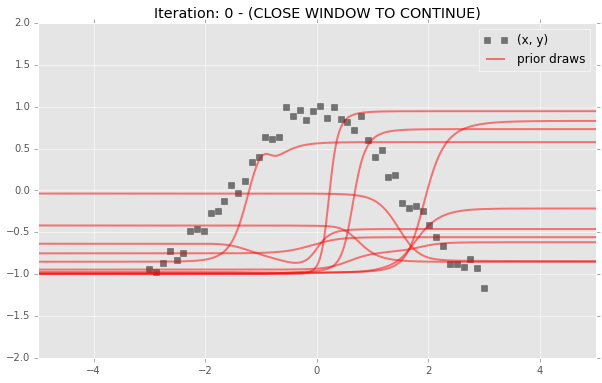

In [11]:
# FIRST VISUALIZATION (prior)

# Sample functions from variational model
mean, std = sess.run([variational.layers[0].loc,
                      variational.layers[0].scale])
rs = np.random.RandomState(0)
zs = rs.randn(10, variational.n_vars) * std + mean
zs = tf.constant(zs, dtype=tf.float32)
inputs = np.linspace(-5, 5, num=400, dtype=np.float32)
x = tf.expand_dims(tf.constant(inputs), 1)
mus = model.neural_network(x, zs)
outputs = mus.eval()
x, y = data['x'], data['y']

# Plot data and functions
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0 - (CLOSE WINDOW TO CONTINUE)")
ax.plot(x, y, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='prior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()


iter 0 loss -233587.36
mean: 
[-1.465446    0.29859465 -0.29911518 -1.4960072   0.30525619 -2.35257387
  1.70042455 -0.49891531  0.93137896 -2.31012225  1.14355969 -1.6454407
 -0.17013095]
std dev: 
[ 0.42407179  0.66674066  1.58875811  0.18226328  0.53817111  1.47194815
  0.89201134  0.28998286  1.15923905  0.63424474  0.97993863  0.2690624
  0.32401404]
iter 100 loss -80117.27
mean: 
[-1.4687475  -0.44616497  2.33822465 -2.92836928 -0.54682267 -3.51472688
  1.598104   -0.48604164  0.43896949 -1.90641296 -0.00846573 -0.68661368
 -0.52450711]
std dev: 
[ 0.05219778  0.24050251  0.10593965  0.30902702  0.24560291  0.28935254
  1.23472393  0.1244592   0.95168537  0.19877662  0.03405753  0.03271953
  0.03624427]
iter 200 loss -14971.28
mean: 
[-1.51239884 -1.87434745  1.820544   -2.31546021 -0.96518582 -2.84580278
  2.90062118 -0.45092919  0.16906884 -1.93784893 -0.80608946 -0.90597486
 -0.82480437]
std dev: 
[ 0.03022716  0.10553651  0.06486955  0.05474068  0.09944309  0.20159654
  0.316

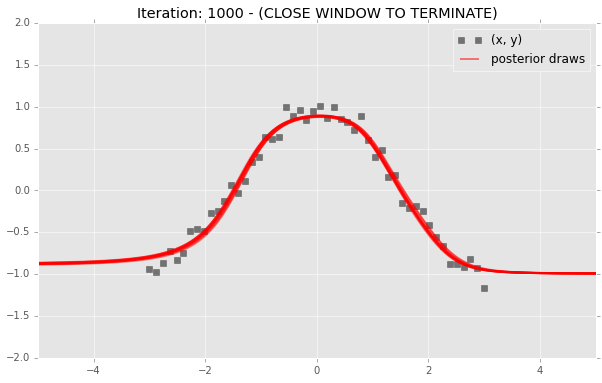

In [12]:
# RUN MEAN-FIELD VARIATIONAL INFERENCE
inference.run(n_iter=1000, n_samples=5, n_print=100)


# SECOND VISUALIZATION (posterior)

# Sample functions from variational model
mean, std = sess.run([variational.layers[0].loc,
                      variational.layers[0].scale])
rs = np.random.RandomState(0)
zs = rs.randn(10, variational.n_vars) * std + mean
zs = tf.constant(zs, dtype=tf.float32)
inputs = np.linspace(-5, 5, num=400, dtype=np.float32)
x = tf.expand_dims(tf.constant(inputs), 1)
mus = model.neural_network(x, zs)
outputs = mus.eval()
x, y = data['x'], data['y']

# Plot data and functions
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 1000 - (CLOSE WINDOW TO TERMINATE)")
ax.plot(x, y, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='posterior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()